In [1]:
import sys
import os
import sqlite3
import pandas as pd
import yaml
from tqdm.notebook import tqdm_notebook
from datetime import datetime

# Install mlflow if not already installed
%pip install mlflow
import mlflow

%pip install optuna
import optuna


# Suggestion on fixed folder structure
'''
/
/scripts        # scripts contains all .py,≈ ipynb files/modules
/scripts/[sub processing modules] # optionally used sub folders for processing modules
/data
/data/sqlite   #contains sqlite database .db
/data/csv     #contains temporary csv files used for scraping
'''


# Adding flag for using with Google Drive or run locally
use_gdrive = False

if use_gdrive:
  from google.colab import drive
  drive.mount('/content/drive')
  root_folder = '/content/drive/MyDrive/'
  print('Using gDrive')
  print(root_folder)
else:
  root_folder = os.getcwd()
  print('Not using gDrive')
  print(root_folder)

# Read config
config = yaml.safe_load(open('../src/scrape_ufc_stats_config.yaml'))

#set folder locations or override config
base_folder = '../'
db_location = base_folder+'data/sqlite_db/sqlite_scrapper.db'
scripts_folder = base_folder+'src'
local_run = False
db_conn = sqlite3.connect(db_location)
cursor = db_conn.cursor()

sys.path.insert(0, '../')
print(sys.path)

os.chdir(scripts_folder)


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/evankellener/Desktop/UFC_fight_predictor/ufc_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Not using gDrive
/Users/evankellener/Desktop/UFC_fight_predictor/notebooks
['../', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python39.zip', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/evankellener/Desktop/UFC_fight_predictor/ufc_env/lib/python3.9/site-packages']


# Setting Up Proper Directory

# Scraping Process

In [ ]:
from scrapper_modules import Eventdetails, Fightdetails, Fightresultsandstats, Fighterdetails, Fightertott
from tqdm.notebook import tqdm_notebook

### Runtime: 0.8s

In [ ]:
ed = Eventdetails(config, db_conn)
#ed_df = ed.process()
ed_df = ed.process()#%Y-%m-%d
ed.save()
db_conn.commit()

### Runtime: 5m 24.2s

In [ ]:
fd = Fightdetails(config, db_conn, list(ed_df['URL']))
fd_df = fd.process()
fd.save()
db_conn.commit()

In [ ]:
frs = Fightresultsandstats(config, db_conn, list(fd_df['URL']))
fr_df, fs_df = frs.process()
frs.save()
db_conn.commit()

In [ ]:
fs_df = pd.read_csv(base_folder+'data/tmp/Fightstats.csv')

In [ ]:
print(fs_df.columns)

In [ ]:
frd = Fighterdetails(config, db_conn)
frd_df = frd.process(filtered_data=fs_df)
frd.save()
db_conn.commit()

Filter Of

In [ ]:
ft = Fightertott(config, db_conn, list(frd_df['URL']))
ft_df = ft.process()
ft_df = ft.save()
db_conn.commit()

In [ ]:
os.chdir(scripts_folder)

## Save Tabels to CSV

In [ ]:
import csv
def save_table_to_csv(db_path, table_name, csv_file_path):
    # Connect to the SQLite database
    connection = sqlite3.connect(db_path)
    cursor = connection.cursor()
    
    try:
        # Query to fetch all rows from the table
        cursor.execute(f"SELECT * FROM {table_name}")
        
        rows = cursor.fetchall()

        # Get column names
        column_names = [description[0] for description in cursor.description]

        # Write to CSV file
        with open(csv_file_path, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow(column_names)  # Write header
            writer.writerows(rows)        # Write data

        print(f"Table '{table_name}' has been saved to '{csv_file_path}'.")
    except sqlite3.Error as e:
        print(f"An error occurred: {e}")
    finally:
        connection.close()

In [ ]:
print(config['event_details_file_name'])
save_table_to_csv(db_location, 'ufc_event_details', base_folder+'data/tmp/ufc_event_details.csv.csv')
save_table_to_csv(db_location, 'ufc_fight_details', base_folder+'data/tmp/Fightdetails.csv')
save_table_to_csv(db_location, 'ufc_fight_results', base_folder+'data/tmp/Fightresults.csv')
save_table_to_csv(db_location, 'ufc_fight_stats', base_folder+'data/tmp/Fightstats.csv')
save_table_to_csv(db_location, 'ufc_fighter_details', base_folder+'data/tmp/Fighterdetails.csv')
save_table_to_csv(db_location, 'ufc_fighter_tott', base_folder+'data/tmp/Fightertott.csv')

In [ ]:
save_table_to_csv(db_location, 'ufc_fight_stats', base_folder+'data/tmp/Fightstats.csv')

# Height Weight Reach Modeling

In [ ]:
import height_weight_reach

In [ ]:
table_name = "ufc_fighter_tott"
predictor = height_weight_reach.hwr_process(db_location, table_name)

### Reach Predictor

In [ ]:
reach_model, reach_mse, reach_r2 = predictor.train_model(['HEIGHT', 'WEIGHT'], 'REACH')
print(f"Reach Model - MSE: {reach_mse}, R^2: {reach_r2}")

### Height Predictor

In [ ]:
height_weights, height_mse, height_r2 = predictor.train_model(['WEIGHT'], 'HEIGHT')
print(f"Height Model - MSE: {height_mse}, R^2: {height_r2}")


In [ ]:
updated_data = predictor.predict_missing_values(['HEIGHT', 'WEIGHT'], 'REACH')

In [ ]:
# Save updated data to database
updated_data.to_sql(os.path.splitext(config['fighter_tott_file_name'])[0], db_conn, if_exists='replace', index=False)

In [ ]:
missing_dob = updated_data[updated_data['DOB'].isnull()]
missing_dob.to_csv(base_folder+'data/tmp/final_data_with_no_dob.csv', index=False)

# Dob Scrapper

In [ ]:
import dob_scrapper

In [ ]:
scraper = dob_scrapper.DOBScraper()

In [ ]:
unfinished_fighter_data = pd.read_csv(base_folder+'data/tmp/final_data_with_no_dob.csv')
for index, row in tqdm_notebook(unfinished_fighter_data.iterrows(), total=unfinished_fighter_data.shape[0]):
    dob = scraper.scrape_dob(row['FIGHTER'])
    print(f"{row['FIGHTER']} - DOB: {dob}")
    unfinished_fighter_data.at[index, 'DOB'] = dob

unfinished_fighter_data.to_csv(base_folder+'data/tmp/final_data_with_dob.csv', index=False)

# SQL Queries

In [ ]:
with open('../src/sql_scripts/reset.sql', 'r') as f:
  sql_weight_fix_script = f.read()

cursor.executescript(sql_weight_fix_script)

### Weight Class Indexing

In [ ]:
with open('../src/sql_scripts/ufc_sql_weightclass.sql', 'r') as f:
  sql_weight_fix_script = f.read()

cursor.executescript(sql_weight_fix_script)

### Match Stats

# Change catch weight and open weight bouts in fight results

In [ ]:
with open('../src/sql_scripts/ufc_sql_match_stats.sql', 'r') as f:
  sql_match_stats = f.read()

cursor.executescript(sql_match_stats)

db_conn.commit()

In [ ]:
with open('../src/sql_scripts/ufc_sql_final_views.sql', 'r') as f:
  sql_final_views = f.read()

cursor.executescript(sql_final_views)
db_conn.commit()

In [ ]:
with open('../src/sql_scripts/test.sql', 'r') as f:
  sql_final_views = f.read()

cursor.executescript(sql_final_views)
db_conn.commit()

In [2]:
import pandas as pd
df = pd.read_sql_query("SELECT * from pre_final", db_conn)
df.to_csv('../data/tmp/pre_final.csv', index=True)

import cleanup_class

cleaner = cleanup_class.Cleanup(df)
cleaner.order_by_date()
#interleaved_df = cleaner.duplicate_and_swap_row()
interleaved_df = cleaner.results_column()

interleaved_df.to_csv('../data/tmp/interleaved_clean.csv', index=True)

/Users/evankellener/Desktop/UFC_fight_predictor/src/cleanup_class.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.df['DATE'] = pd.to_datetime(self.df['DATE'], errors='coerce')


In [3]:
from elo_class_fixed import FightDataProcessor
# Add WINNER column from existing `result` column if it's present
if 'result' in interleaved_df.columns:
    interleaved_df['WINNER'] = interleaved_df.apply(
        lambda row: row['FIGHTER'] if row['result'] == 1 else row['opp_FIGHTER'], axis=1
    )

interleaved_df.to_csv('../data/tmp/interleaved_clean.csv', index=False)

In [4]:
from gpt_elo_best_time_finnish import EnhancedElo
from striking_elo import StrikingElo
from grappling_elo import GrapplingElo

processor = FightDataProcessor('../data/tmp/interleaved_clean.csv')
raw_data = processor.load_data()
raw_data.to_csv('../data/tmp/interleaved_raw.csv')
cleaned_data = processor.clean_data()
cleaned_data.to_csv('../data/tmp/interleaved_cleaned.csv')

/Users/evankellener/Desktop/UFC_fight_predictor/src/elo_class_fixed.py:13: DtypeWarning: Columns (7,8,9,10,11,12,13,16,17,18,19,20,21,22,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258

In [5]:
from gpt_elo_best_time_finnish import EnhancedElo
from striking_elo import StrikingElo
from new_striking_elo import NewStrikingElo
from grappling_elo import GrapplingElo
from glicko import SimpleGlicko
import pandas as pd

cleaned_data = pd.read_csv('../data/tmp/interleaved_cleaned.csv')
cleaned_data['precomp_boutcount'] = pd.to_numeric(cleaned_data['precomp_boutcount'], errors='coerce')
cleaned_data['opp_precomp_boutcount'] = pd.to_numeric(cleaned_data['opp_precomp_boutcount'], errors='coerce')
cleaned_data['age'] = pd.to_numeric(cleaned_data['age'], errors='coerce')
cleaned_data['opp_age'] = pd.to_numeric(cleaned_data['opp_age'], errors='coerce')
cleaned_data['DATE'] = pd.to_datetime(cleaned_data['DATE']) 
elo_calculator = EnhancedElo(k_factor=32)
results_with_elo = elo_calculator.process_fights(cleaned_data)
elo_calculator.top_n_fighters(10)
#elo_calculator.query_fighter_elo('Jon Jones')

#glicko_calculator = SimpleGlicko()
#results_with_elo = glicko_calculator.process_fights(cleaned_data)
#display top fighters
#glicko_calculator.top_k_fighters(10)
#glicko_calculator.query_fighter_glicko('Jon Jones')




# Create age ratio features
results_with_elo['age_ratio_difference'] = results_with_elo['age'] / results_with_elo['opp_age'] - 1
results_with_elo['opp_age_ratio_difference'] = results_with_elo['opp_age'] / results_with_elo['age'] - 1

#striking elo calculation

cols_to_numeric = [
    "sigstracc", "sigstrabs",
    "opp_sigstracc", "opp_sigstrabs"
]
results_with_elo[cols_to_numeric] = results_with_elo[cols_to_numeric].apply(pd.to_numeric, errors='coerce')


results_with_elo["f_eff"] = results_with_elo["sigstracc"] - results_with_elo["sigstrabs"]
results_with_elo["o_eff"] = results_with_elo["opp_sigstracc"] - results_with_elo["opp_sigstrabs"]
results_with_elo["strike_diff"] = results_with_elo["f_eff"] - results_with_elo["o_eff"]


striking_elo_calculator = StrikingElo(k_factor=35)
results_with_elo = striking_elo_calculator.process_fights(results_with_elo)
results_with_elo['precomp_strike_elo'] = results_with_elo['precomp_strike_elo'].fillna(0)
results_with_elo['opp_precomp_strike_elo'] = results_with_elo['opp_precomp_strike_elo'].fillna(0)
striking_elo_calculator.top_n_fighters(10)

striking_elo_calculator = NewStrikingElo(k_off=35, k_def=35)
results_with_elo = striking_elo_calculator.process_fights(results_with_elo)
results_with_elo['precomp_strike_elo'] = results_with_elo['precomp_strike_elo'].fillna(0)
results_with_elo['opp_precomp_strike_elo'] = results_with_elo['opp_precomp_strike_elo'].fillna(0)
striking_elo_calculator.top_n_offense(10)
striking_elo_calculator.top_n_defense(10)


#grappling elo calculation

grappling_elo_calculator = GrapplingElo(k_factor=32)
results_with_elo = grappling_elo_calculator.process_fights(results_with_elo)
results_with_elo['precomp_grapple_elo'] = results_with_elo['precomp_grapple_elo'].fillna(0)
results_with_elo['opp_precomp_grapple_elo'] = results_with_elo['opp_precomp_grapple_elo'].fillna(0)
grappling_elo_calculator.top_n_fighters(10)

results_with_elo.to_csv('../data/tmp/interleaved_with_elo.csv')

print(results_with_elo.head())


/var/folders/pb/dv2jn_dd3130kmmtjzyzw62m0000gn/T/ipykernel_98332/1037935770.py:8: DtypeWarning: Columns (8,9,10,11,12,13,14,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,25

Top 10 Fighters by Elo:
Islam Makhachev: 1927.02
Ilia Topuria: 1812.39
Merab Dvalishvili: 1809.37
Jon Jones: 1807.69
Khabib Nurmagomedov: 1796.17
Khamzat Chimaev: 1788.17
Magomed Ankalaev: 1770.66
Francis Ngannou: 1754.83
Demetrious Johnson: 1739.66
Shavkat Rakhmonov: 1732.24
Top 10 Fighters by Elo:
1. Georges St-Pierre: 1772.33
2. Max Holloway: 1743.58
3. Demetrious Johnson: 1741.48
4. Jon Jones: 1729.04
5. Alexander Volkanovski: 1726.14
6. Merab Dvalishvili: 1704.23
7. Ciryl Gane: 1703.13
8. Magomed Ankalaev: 1692.42
9. Aljamain Sterling: 1689.95
10. Amanda Nunes: 1687.60
Top 10 Fighters by Offense Elo:
1. Cain Velasquez: 6825.02
2. Georges St-Pierre: 6403.35
3. Katsuhisa Fujii: 5158.34
4. Jon Fitch: 4425.77
5. Umar Nurmagomedov: 4297.13
6. Abdul-Kerim Edilov: 4172.11
7. Amanda Nunes: 4168.44
8. Dan Severn: 4166.68
9. Matt Hughes: 4166.67
10. Derrick Lewis: 4109.19
Top 10 Fighters by Defense Elo:
1. Georges St-Pierre: 1759.12
2. Jon Jones: 1732.21
3. Zhang Weili: 1652.34
4. Ciryl Gan

In [6]:
from elo_feature_enhancer import EloFeatureEnhancer

data = pd.read_csv('../data/tmp/interleaved_with_elo.csv')

editor = EloFeatureEnhancer('../data/tmp/interleaved_with_elo.csv')

#arrage elo features in the proper place
#ordered_data = editor.insert_elo_features_in_order()

#ordssered_data.to_csv('../data/tmp/ordered.csv')

# Confirm precomp postcomp - Store fighter's most recent postcomp stats
# and check consistency between precomp and previous postcomp values
#editor.verify_precomp_postcomp_consistency()
#editor.store_fighter_postcomp_stats()

filtered_data = editor.filter_by_fight_count(min_fights=1)
filtered_data.to_csv('../data/tmp/filtered.csv')

cols_to_numeric = [
    'precomp_strike_elo', 'opp_precomp_strike_elo',
    'precomp_grapple_elo', 'opp_precomp_grapple_elo',
    'precomp_elo', 'opp_precomp_elo'
]
filtered_data[cols_to_numeric] = filtered_data[cols_to_numeric].apply(pd.to_numeric, errors='coerce')
filtered_data

swapped_data = editor.duplicate_and_swap_rows()
swapped_data.to_csv('../data/tmp/swapped.csv')

diff_data = editor.differential_and_rolling_stats(swapped_data)
diff_data.to_csv('../data/tmp/diff_data.csv')

for col in swapped_data.columns:
    swapped_data[col] = pd.to_numeric(swapped_data[col], errors='ignore')

float_cols = swapped_data.select_dtypes(include=['float64', 'float32']).columns

swapped_data[float_cols] = swapped_data[float_cols].applymap(lambda x: round(x, 2) if pd.notnull(x) else x)

if 'DATE' in swapped_data.columns:
    swapped_data['DATE'] = pd.to_datetime(swapped_data['DATE'], errors='coerce').dt.strftime('%Y-%m-%d')

swapped_data.to_csv('../data/tmp/final.csv', index=False, float_format='%.2f')

/var/folders/pb/dv2jn_dd3130kmmtjzyzw62m0000gn/T/ipykernel_98332/3917756910.py:3: DtypeWarning: Columns (9,10,11,13,14,15,18,19,20,21,22,23,24,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,52,53,54,55,57,58,59,60,61,62,63,65,66,67,68,69,70,71,73,74,75,76,77,78,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,26

Filtering by minimum precomp_boutcount: 1
Filtering complete: 7966 -> 5960 rows (2006 removed)


In [ ]:
#save a copy of the final data with the fighter names, elo ratings and fight results
swapped_data[['FIGHTER','precomp_elo','postcomp_elo', 'opp_FIGHTER', 'opp_precomp_elo', 'opp_postcomp_elo', 'win']].to_csv('../data/tmp/final_fighter_elo.csv', index=False, float_format='%.2f')

In [ ]:
elo_calculator.query_fighter_elo('Alexandre Pantoja')

In [ ]:
elo_calculator.top_n_fighters(70)

# Predictions/Models

In [ ]:
from model import DNNFightPredictor

predictor = DNNFightPredictor(file_path = '../data/tmp/final.csv')

In [ ]:
predictor.hyperparameter_tuning()

In [7]:
from ensemble_model_best import FightOutcomeModel
fight_model = FightOutcomeModel('../data/tmp/final.csv')

Removed out-of-bounds entries:
  draftkings_odds: 166 rows removed
  fanduel_odds: 140 rows removed
  betmgm_odds: 224 rows removed
  bet365_odds: 1190 rows removed
  bovada_odds: 338 rows removed

Filtered data written to final_with_odds_filtered.csv
Creating a new scaler...
Training set size: 8844
Test set size: 704
Feature count: 52

🔍 Data Split Diagnostics:
Train win rate: 0.497
Test  win rate: 0.497

Train feature summaries:
                                   count         mean        std      min  \
precomp_elo                      8844.0  1518.709050  62.612157  1232.53   
opp_precomp_elo                  8844.0  1518.709050  62.612157  1232.53   
precomp_elo_change_3             8844.0     3.163323  43.541179  -175.30   
opp_precomp_elo_change_3         8844.0     3.163323  43.541179  -175.30   
precomp_elo_change_5             8844.0     6.970635  49.981046  -212.30   
opp_precomp_elo_change_5         8844.0     6.970635  49.981046  -212.30   
precomp_tdavg3                  

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

df  = pd.read_csv('../data/tmp/final.csv')

# 1. Column split
num_cols = [c for c in df.columns if c.startswith('precomp_') or c.startswith('opp_precomp_')]
cat_cols = ['STANCE']  # plus any others

preprocessor = ColumnTransformer([
    ('nums', Pipeline([('scale', StandardScaler()), 
                       ('pca', PCA(n_components=0.95, svd_solver='full'))]),
     num_cols),
    ('cats', OneHotEncoder(handle_unknown='ignore'),
     cat_cols),
])

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 1.0,
    'use_label_encoder': False
}

nn_params = {
    'hidden_layer_sizes': (100, 100, 100, 50),   # two layers: 100 units then 50 units
    'activation': 'relu',
    'solver': 'adam',
    'learning_rate_init': 0.001,
    'alpha': 0.0001,                   # L2 regularization term
    'batch_size': 32,
    'max_iter': 300,
    'early_stopping': True,
    'random_state': 42
}

# 2. Build your pipeline (assuming `preprocessor` is already defined)
pipe = Pipeline([
    ('prep', preprocessor),
    ('clf', MLPClassifier(**nn_params))
])
# Then grid‐search over e.g. number of PCA components or classifier hyperparams.


param_grid = {
    'prep__nums__pca__n_components': [0.80, 0.90, 0.95],
    'clf__hidden_layer_sizes': [(100,100,100,50), (50,50,25), (100,50)],
    'clf__alpha': [1e-4, 1e-3, 1e-2],
    'clf__learning_rate_init': [1e-3, 1e-2],
}


In [ ]:
X_train, y_train, X_test, y_test = fight_model._prepare_data()


grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_score_)

# 2. Fit the pipeline on your training set
pipe.fit(X_train, y_train)

# 3. Print train/test scores
print("Train accuracy:", pipe.score(X_train, y_train))
print("Test accuracy: ", pipe.score(X_test, y_test))

# 4. (Optional) Inspect how many PCA components were kept
pca_step = pipe.named_steps['prep'].named_transformers_['nums'].named_steps['pca']
print("Number of PCs retained:", pca_step.n_components_)
print("Explained variance ratio:", pca_step.explained_variance_ratio_.sum())


In [ ]:

results = fight_model.evaluate_top_k_feature_subsets(k=10)

# For example, get the best result (lowest log loss or highest accuracy):
best_log_loss = min(results, key=lambda r: r['log_loss'])  # or use max(r, key=lambda r: r['accuracy'])
best_accuracy = max(results, key=lambda r: r['accuracy'])


selected_features_ll = best_log_loss['features']
acc_ll = best_log_loss['accuracy']
loss_ll = best_log_loss['log_loss']

selected_features_ac = best_log_loss['features']
acc_ac = best_log_loss['accuracy']
loss_ac = best_log_loss['log_loss']


print("Best result based on log loss:")
print("Best features:", selected_features_ll)
print("Best accuracy:", acc_ll)
print("Best log loss:", loss_ll)

print("Best k:", best_log_loss['k'])
print("Best features:", selected_features_ll)
print("Accuracy:", acc_ll)
print("Log Loss:", loss_ll)

print("Best result based on accuracy:")
print("Best features:", selected_features_ll)
print("Best accuracy:", acc_ac)
print("Best log loss:", loss_ac)

print("Best k:", best_log_loss['k'])
print("Best features:", selected_features_ac)
print("Accuracy:", acc_ac)
print("Log Loss:", loss_ac)


In [ ]:
fight_model.covariance_feature_analysis(top_n=50)

In [ ]:
fight_model.find_best_feature_to_add()

In [ ]:
fight_model.roi_features_to_add(vegas_data_path='final_with_odds.csv')

Best params: {'clf__C': 0.01, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Train accuracy: 0.622
Log loss: 0.618
Test accuracy: 0.675
95% CI for test accuracy: 0.639 - 0.708

      DATE                            EVENT                                  BOUT           FIGHTER  prob_win  odds
2024-08-17 UFC 305: Du Plessis vs. Adesanya Dricus Du Plessis vs. Israel Adesanya Dricus Du Plessis     0.603  -152
2024-08-17 UFC 305: Du Plessis vs. Adesanya Dricus Du Plessis vs. Israel Adesanya   Israel Adesanya     0.391   156
2024-08-17 UFC 305: Du Plessis vs. Adesanya        Josh Culibao vs. Ricardo Ramos      Josh Culibao     0.631  -171
2024-08-17 UFC 305: Du Plessis vs. Adesanya        Josh Culibao vs. Ricardo Ramos     Ricardo Ramos     0.357   180
2024-08-17 UFC 305: Du Plessis vs. Adesanya         Junior Tafa vs. Valter Walker       Junior Tafa     0.500  -100
SHAP not available - skipping feature importance analysis
Logistic Regression Accuracy: 0.6747159

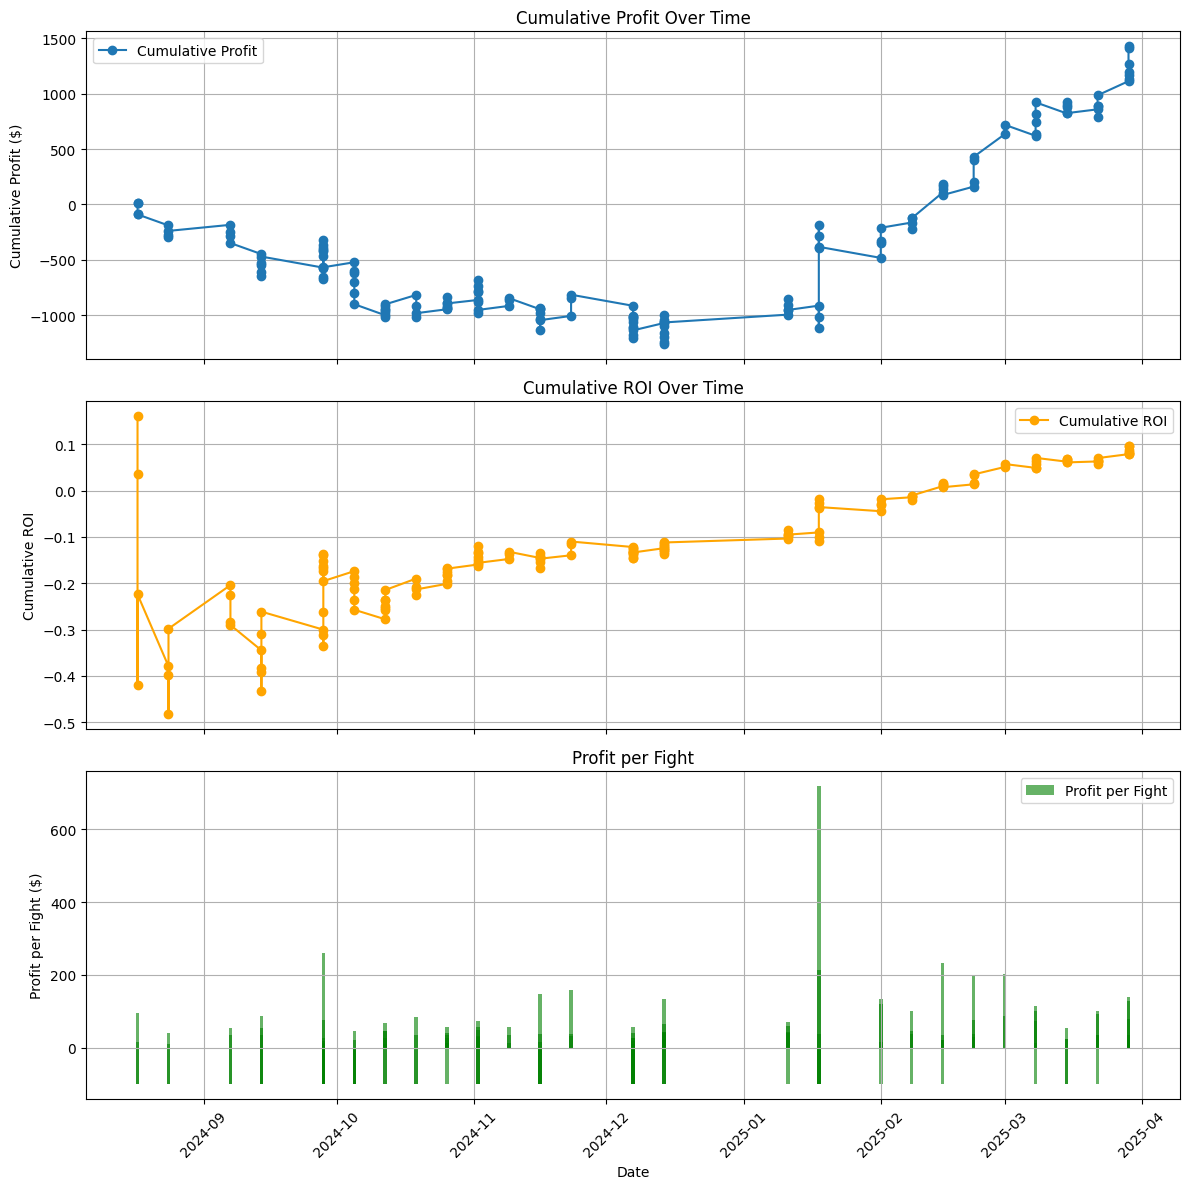

In [8]:
model, acc = fight_model.tune_logistic_regression()
print(f"Logistic Regression Accuracy: {acc}")
odd_df = fight_model.generate_odds_table()

output_path = '../data/tmp/odds_table.csv'
odd_df.to_csv(output_path, index=False)
print(f"Odds table saved to {output_path}")

roi_df = fight_model.calculate_roi(
    odds_table_path='../data/tmp/odds_table.csv',
    vegas_data_path='final_with_odds.csv'
)

Just elo

Log loss: 0.6590771758930642
Accuracy: 0.6177215189873417

self.importance_columns = [
            'precomp_elo', 'precomp_elo_change_3', 'precomp_elo_change_5',
            'opp_precomp_elo',  'opp_precomp_elo_change_3', 'opp_precomp_elo_change_5',
            'WEIGHT', 'age', 'opp_WEIGHT', 'age_ratio_difference', 'opp_age_ratio_difference',
            'REACH', 'opp_REACH','opp_age','precomp_legacc_perc','opp_weight_of_fight','opp_precomp_legacc_perc', 'precomp_sigstr_pm5',
            'precomp_sigstr_pm3', 'precomp_tdavg3', 'precomp_sapm3', 'precomp_subavg3',
            'precomp_tddef3', 'precomp_sigstr_perc3', 'precomp_strdef3', 'precomp_tdacc_perc3',
            'precomp_totalacc_perc3', 'precomp_headacc_perc3', 'precomp_bodyacc_perc3', 'precomp_legacc_perc3',
            'precomp_distacc_perc3', 'precomp_clinchacc_perc3', 'precomp_groundacc_perc3',
            'precomp_winsum3', 'precomp_losssum3', 
            'opp_precomp_sigstr_pm3', 'opp_precomp_tdavg3', 'opp_precomp_sapm3', 'opp_precomp_subavg3',
            'opp_precomp_tddef3', 'opp_precomp_sigstr_perc3', 'opp_precomp_strdef3', 'opp_precomp_tdacc_perc3',
            'opp_precomp_totalacc_perc3', 'opp_precomp_headacc_perc3', 'opp_precomp_bodyacc_perc3', 'opp_precomp_legacc_perc3',
            'opp_precomp_distacc_perc3', 'opp_precomp_clinchacc_perc3', 'opp_precomp_groundacc_perc3',
            'opp_precomp_winsum3', 'opp_precomp_losssum3',
        ]

13     precomp_legacc_perc  0.688608  0.617334

In [ ]:
model, acc = fight_model.build_mlp()
print(f"MLP Accuracy: {acc}")

In [ ]:
model, acc = fight_model.tune_svm()
print(f"SVM Accuracy: {acc}")

In [ ]:
model, acc = fight_model.tune_xgboost()
print(f"XBGoost Accuracy: {acc}")
print("Best parameters for XGBoost:")
print(model.get_params())

In [ ]:
model, acc = fight_model.train_ensemble()
print(f"Ensemble Model Accuracy: {acc}")

In [ ]:
model, acc = fight_model.custom_soft_voting_ensemble()
print(f"Custom Soft Voting Ensemble Model Accuracy: {acc}")

In [ ]:
acc = fight_model.basic_elo_pred()
print(f"Basic Elo Prediction Accuracy: {acc}")
log_loss = fight_model.elo_log_loss()
print(f"Log Loss: {log_loss}")

fight_model.print_top_n_fighters_by_elo(n=60)

In [ ]:
fight_model.analyze_elo_accuracy_by_event()

In [ ]:
fight_model.evaluate_top_k_feature_subsets(k=46)

In [ ]:
fight_model.hierarchical_feature_selector()

In [ ]:
fight_model.print_fighter_elo("Islam Makhachev")

Islam Makhachev 1798.51

Pantoja 1657.03
Ilia Topuria 1651.26
Jon Jones 1581.49

In [ ]:
fight_model.plot_elo_distribution()

In [ ]:
fight_model.plot_elo_vs_outcome()

In [ ]:
fight_model.plot_feature_importance(model)

k=35: 53.6%
k=30 with method weighting: 54.1%
k=30 with porportion based method weighting: 55.6%

sigmoid scaler:
400 =  log loss of 0.6691
350 = log loss of 0.6670
300 = log loss of 0.6647
270 = log loss of 0.6633
240 = log loss of 0.6621
200 = log loss of 0.6611

Highest Accuracy and Log Loss attained was accuracy of 

In [ ]:
predictor.evaluate_generalization()

In [ ]:
data = predictor.evaluate_generalization_with_postcomp_stats()

In [ ]:
data.to_csv('../data/tmp/final_evaluation.csv', index=False)

In [ ]:
#export fighter data
pre_final_data = pd.read_csv('../data/tmp/pre_final.csv')
filtered_pf = pre_final_data[pre_final_data['FIGHTER'] == 'Alexandre Pantoja']

In [ ]:
filtered_pf.to_csv('../data/tmp/fighter_filtered_final.csv')

In [ ]:
predictor.predict_with_postcomp_data('Alex Pereira', 'Magomed Ankalaev', weight1=205, weight2=205)
predictor.predict_with_postcomp_data('Justin Gaethje', 'Rafael Fiziev', weight1=155, weight2=155)
predictor.predict_with_postcomp_data('Jalin Turner', 'Ignacio Bahamondes', weight1=155, weight2=155)
predictor.predict_with_postcomp_data('King Green', 'Mauricio Ruffy', weight1=155, weight2=155)
predictor.predict_with_postcomp_data('Joshua Van', 'Rei Tsuruya', weight1=125, weight2=125)
predictor.predict_with_postcomp_data('Bruno Fe', 'Rei Tsuruya', weight1=125, weight2=125)

# Predict Kape vs Almabayev

In [ ]:
predictor.mlflow_run()

In [ ]:
predictor = DNNFightPredictor(file_path = '../data/tmp/interleaved_results_elo_hist_1_removed.csv')
predictor.hyperparameter_tuning()

# Elo Comparisson
* old data + elo columns(2) = 0.664

{'learning_rate': 2.661075089731784e-05,
 'batch_size': 64,
 'dropout_rate': 0.4113464221107168,
 'l2_reg': 0.0067498143500825235,
 'layer_size_0': 64,
 'layer_size_1': 48,
 'layer_size_2': 32,
 'layer_size_3': 112}

* new data + elo columns(2) = 0.666




In [ ]:
predictor.shap_analysis()

In [ ]:
predictor.predict_fight_winner('Merab Dvalishvili', 'Umar Nurmagomedov')

# Best Hyperparameters for elo columns

{'learning_rate': 0.001441126615791276,
 'batch_size': 64,
 'dropout_rate': 0.35954714170732943,
 'l2_reg': 0.0030518395936230975,
 'layer_size_0': 80,
 'layer_size_1': 32}

selected_features = [
            'age', 'HEIGHT', 'WEIGHT', 'REACH', 'weightindex', 
            'precomp_sigstr_pm', 'precomp_tdavg', 'precomp_sapm', 'precomp_subavg',
            'precomp_tddef', 'precomp_sigstr_perc', 'precomp_strdef', 'precomp_tdacc_perc',
            'precomp_totalacc_perc', 'precomp_headacc_perc', 'precomp_bodyacc_perc', 'precomp_legacc_perc',
            'precomp_distacc_perc','precomp_clinchacc_perc','precomp_groundacc_perc','precomp_winsum', 'precomp_losssum',
            'precomp_sigstr_pm3', 'precomp_tdavg3', 'precomp_sapm3', 'precomp_subavg3',
            'precomp_tddef3', 'precomp_sigstr_perc3', 'precomp_strdef3', 'precomp_tdacc_perc3',
            'precomp_totalacc_perc3', 'precomp_headacc_perc3', 'precomp_bodyacc_perc3', 'precomp_legacc_perc3',
            'precomp_distacc_perc3','precomp_clinchacc_perc3','precomp_groundacc_perc3',
            'precomp_winsum3', 'precomp_losssum3',
            'precomp_sigstr_pm5', 'precomp_tdavg5', 'precomp_sapm5', 'precomp_subavg5',
            'precomp_tddef5', 'precomp_sigstr_perc5', 'precomp_strdef5', 'precomp_tdacc_perc5',
            'precomp_totalacc_perc5', 'precomp_headacc_perc5', 'precomp_bodyacc_perc5', 'precomp_legacc_perc5',
            'precomp_distacc_perc5','precomp_clinchacc_perc5','precomp_groundacc_perc5',
            'precomp_winsum5', 'precomp_losssum5',
            'precomp_elo','elo_diff_pre', 'precomp_elo_change_3', 'precomp_elo_change_5', 
            'opp_age', 'opp_HEIGHT', 'opp_WEIGHT', 'opp_REACH','opp_weightindex',
            'opp_precomp_sigstr_pm', 'opp_precomp_tdavg', 'opp_precomp_sapm', 'opp_precomp_subavg',
            'opp_precomp_tddef', 'opp_precomp_sigstr_perc', 'opp_precomp_strdef', 'opp_precomp_tdacc_perc',
            'opp_precomp_totalacc_perc', 'opp_precomp_headacc_perc','opp_precomp_bodyacc_perc','opp_precomp_legacc_perc',
            'opp_precomp_distacc_perc','opp_precomp_clinchacc_perc','opp_precomp_groundacc_perc','opp_precomp_winsum', 'opp_precomp_losssum',
            'opp_precomp_sigstr_pm3', 'opp_precomp_tdavg3', 'opp_precomp_sapm3', 'opp_precomp_subavg3',
            'opp_precomp_tddef3', 'opp_precomp_sigstr_perc3', 'opp_precomp_strdef3', 'opp_precomp_tdacc_perc3',
            'opp_precomp_totalacc_perc3', 'opp_precomp_headacc_perc3','opp_precomp_bodyacc_perc3','opp_precomp_legacc_perc3',
            'opp_precomp_distacc_perc3','opp_precomp_clinchacc_perc3','opp_precomp_groundacc_perc3',
            'opp_precomp_winsum3', 'opp_precomp_losssum3','opp_weight_avg3',
            'opp_precomp_elo','opp_elo_diff_pre', 'opp_precomp_elo_change_3', 'opp_precomp_elo_change_5',
            'opp_precomp_sigstr_pm5', 'opp_precomp_tdavg5', 'opp_precomp_sapm5', 'opp_precomp_subavg5',
            'opp_precomp_tddef5', 'opp_precomp_sigstr_perc5', 'opp_precomp_strdef5', 'opp_precomp_tdacc_perc5',
            'opp_precomp_totalacc_perc5', 'opp_precomp_headacc_perc5','opp_precomp_bodyacc_perc5','opp_precomp_legacc_perc5',
            'opp_precomp_distacc_perc5','opp_precomp_clinchacc_perc5','opp_precomp_groundacc_perc5',
            'opp_precomp_winsum5', 'opp_precomp_losssum5','opp_precomp_elo_change_5',
        ]



        {'learning_rate': 0.0004982871706745808,
 'batch_size': 16,
 'dropout_rate': 0.4512401787251757,
 'l2_reg': 0.0005124681578208401,
 'layer_size_0': 128,
 'layer_size_1': 80,
 'layer_size_2': 64,
 'layer_size_3': 32}

In [ ]:
import pandas as pd

# Creating the data for the CSV file
data = [
    ["Song Yadong", "Henry Cejudo", "Song Yadong"],
    ["Anthony Hernandez", "Brendan Allen", "Anthony Hernandez"],
    ["Rob Font", "Jean Matsumoto", "Rob Font"],
    ["Jean Silva", "Melsik Baghdasaryan", "Jean Silva"],
    ["Alonzo Menifield", "Julius Walker", "Alonzo Menifield"],
    ["Ion Cuțelaba", "Ibo Aslan", "Ion Cuțelaba"],
    ["Melquizael Costa", "Andre Fili", "Melquizael Costa"],
    ["Mansur Abdul-Malik", "Nick Klein", "Mansur Abdul-Malik"],
    ["Ricky Simón", "Javid Basharat", "Ricky Simón"],
    ["Austin Vanderford", "Nikolay Veretennikov", "Austin Vanderford"],
    ["Nursulton Ruziboev", "Eric McConico", "Nursulton Ruziboev"],
    ["Modestas Bukauskas", "Raffael Cerqueira", "Modestas Bukauskas"],
    ["Manel Kape", "Asu Almabayev", "Manel Kape"],
    ["Cody Brundage", "Julian Marquez", "Cody Brundage"],
    ["Nasrat Haqparast", "Esteban Ribovics", "Nasrat Haqparast"],
    ["Hyder Amil", "William Gomis", "Hyder Amil"],
    ["Sam Patterson", "Danny Barlow", "Sam Patterson"],
    ["Mário Pinto", "Austen Lane", "Mário Pinto"],
    ["Chepe Mariscal", "Ricardo Ramos", "Chepe Mariscal"],
    ["Danny Silva", "Lucas Almeida", "Danny Silva"],
    ["JJ Aldrich", "Andrea Lee", "JJ Aldrich"],
    ["Ramazan Temirov", "Charles Johnson", "Ramazan Temirov"]
]

# Creating a DataFrame
df = pd.DataFrame(data, columns=["Fighter A", "Fighter B", "Winner"])

# Exporting the DataFrame to a CSV file
file_path = "../data/tmp/UFC_Fight_Night_Results.csv"
df.to_csv(file_path, index=False)

# Providing the file to the user
file_path
